Goal: Determine the most important indicators influencing the attrition rate across all small private liberal arts college based on 2016-2017 publically available data. Data obtained through the API at https://nces.ed.gov/ipeds/datacenter/reportmain.aspx. 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn import preprocessing
df=pd.read_csv('Data_5-4-2019_2.csv')

Create attrition rate and test optional features, along with dropping non-numeric columns and filling missing values with column means. 

In [2]:
df['SAT Optional']=0
df['SAT Optional'][df['SAT Critical Reading 25th percentile score (ADM2016_RV)'].isna()==True]=1
df['ACT Optional']=0
df['ACT Optional'][df['SAT Critical Reading 25th percentile score (ADM2016_RV)'].isna()==True]=1
df['Test Optional']=0
df['Test Optional'][(df['SAT Optional']==1) & (df['ACT Optional']==1)]=1
df['Attrition']=100-df['Full-time retention rate  2016 (EF2016D_RV)']
df=df.drop(['SAT Optional', 'ACT Optional', 'Full-time retention rate  2016 (EF2016D_RV)', 'instnm', 'Unnamed: 28' ], axis=1)
df=df.fillna(df.mean()).dropna(axis=1, how='all')

/Users/miweb002/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/miweb002/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/miweb002/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Use Random Forest Regressor to determine relative importance of features. 

Text(0.5,0,'Relative Importance')

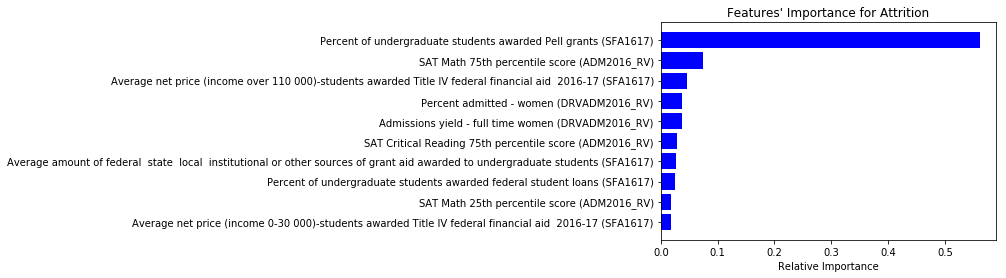

In [3]:
model = RandomForestRegressor(random_state=1, max_depth=10)
model.fit(df[ df.columns[df.columns!='Attrition'] ],df['Attrition'])


features = df[ df.columns[df.columns!='Attrition'] ].columns
importances = model.feature_importances_
indices = np.argsort(importances)[-10:]  # top 10 features
fig1=plt.figure()
plt.title('Features\' Importance for Attrition')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')

Keeping the top ten features in terms of relative importance, we fit a linear multiple regression model to the data to infer features' impact on attrition rate. Note the regression model is normalized so slopes should be interpreted in terms of change in standard deviations. 

In [6]:
X_scaled=preprocessing.scale(df[ df.columns[df.columns!='Attrition'] ][features[indices]])
y_scaled=preprocessing.scale(df['Attrition'])
lr=linear_model.LinearRegression()
predicted=lr.fit(X=X_scaled,y=y_scaled)
values=predicted.coef_
names = [features[i] for i in indices]
results=pd.DataFrame(values, index=names, columns=['Coefficients in Linear Model'])

pd.set_option('display.max_colwidth', 75)
print(results)

                                                                             Coefficients in Linear Model
Average net price (income 0-30 000)-students awarded Title IV federal fi...                      0.132181
SAT Math 25th percentile score (ADM2016_RV)                                                      0.162653
Percent of undergraduate students awarded federal student loans (SFA1617)                       -0.095732
Average amount of federal  state  local  institutional or other sources ...                      0.036916
SAT Critical Reading 75th percentile score (ADM2016_RV)                                         -0.080192
Admissions yield - full time women (DRVADM2016_RV)                                              -0.103565
Percent admitted - women (DRVADM2016_RV)                                                         0.065830
Average net price (income over 110 000)-students awarded Title IV federa...                     -0.272705
SAT Math 75th percentile score (ADM2016_RV)   

/Users/miweb002/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


According the multiple regression model, increasing the SAT Math 75th percentile score by one standard deviation has the largest effect in reducing attrition, whereas increasing Pell Grant recipients by one standard deviation has the largest effect in increasing the attrition rate. In totality, the cofficients, along with the Random Forest analysis, suggest preparation in mathematics and low-income students have the largest impact on the attrition. However, small liberal arts colleges simply, for both financial and ethical reasons, cannot turn way eligible, low-income students. 

Investigate further dimensionality reduction for future regression work by applying Principal Component Analysis to the original model and the model already with reduced dimensionality from the Random Forest Regressor investigation. 

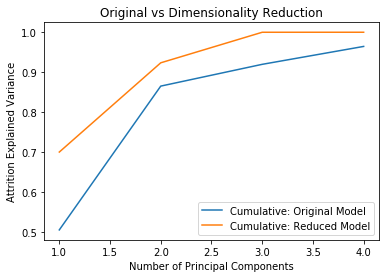

In [7]:
pca = PCA(n_components=4)
pca_result = pca.fit_transform(df[df.columns[df.columns!='Attrition']].values)
plt.plot(range(1,5), np.cumsum(pca.explained_variance_ratio_),label='Cumulative: Original Model')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.title("Principal Components' Explained Variance")
plt.legend()

pca_result2 = pca.fit_transform(df[ df.columns[df.columns!='Attrition'] ][features[indices]].values)
plt.plot(range(1,5), np.cumsum(pca.explained_variance_ratio_),label='Cumulative: Reduced Model')
plt.xlabel('Number of Principal Components')
plt.ylabel('Attrition Explained Variance')
plt.title("Original vs Dimensionality Reduction")
plt.legend()

Principal Component Analysis suggests one can reduce the dimensionality to 3 components in order to achieve essentially 100% of the explained variance.

Based on the importance of the 75th percentile Math SAT scores and percentage of Pell grant recipients, we invetigate changes over time from 2011-2016, which is equivalent to the 2011-2012 through 2016-2017 academic years. 

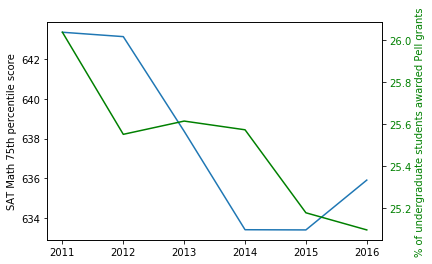

In [8]:
df=pd.read_csv('Data_5-5-2019.csv')
df.drop(['instnm', 'Unnamed: 14'], axis=1, inplace=True)

fig4 = plt.figure()
ax1 = fig4.add_subplot(111)
ax1.plot([2011, 2012, 2013, 2014, 2015, 2016], np.flip(df.mean().iloc[0:6].values))
ax1.set_ylabel('SAT Math 75th percentile score')

ax2 = ax1.twinx()
ax2.plot([2011, 2012, 2013, 2014, 2015, 2016], np.flip(df.mean().iloc[6:12].values), 'g-')
ax2.set_ylabel('% of undergraduate students awarded Pell grants', color='g')
for tl in ax2.get_yticklabels():
    tl.set_color('g')

Here we see that the SAT Math 75th percentile scores at small liberal arts colleges have been trending down. The small increase from 2015 to 2016 (3 points) is not a trend and could be due to the new SAT exam released in 2016. Generally speaking the Math SAT 75th percentile scores are trending down, which suggest a college mathematics preparedness issue. Although the percent of Pell Grant recipients at small liberal arts colleges are trending down, colleges cannot turn away qualified, low-income students. 

Academic Programming Suggestion: Create a summer bridge program that prepares students for college mathematics during the 4 weeks prior to their first semester of college. Such a program will require resources, typically the cost of an adjunct professor per 20 students. However, if such a program reduces attrition, then the program will more than pay for itself. Reducing attrition by one students saves around 26,000 dollars on average or around 17,000 dollars per student with a family income of less than 48K. 

Upon request a suggestion summer bridge mathematics curriculum can be provided. 